In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
import json
import re
import random
import csv
from tqdm.auto import tqdm
import pandas as pd
# install bitsandbytes and restart

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def load_json_from_drive(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

tomi_train = load_json_from_drive("/content/drive/MyDrive/SEF/Data/ToMi/tomi_train.json")
tomi = [ex for ex in tomi_train if ex.get("question_type") == "belief"]
print(f"Loaded {len(tomi)} belief questions from tomi_train.")

Loaded 71 belief questions from tomi_train.


In [4]:
model_id = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "left"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
     

# Intervention with Forward Hooks

In [5]:
import numpy as np
tomi_weights = np.load('/content/drive/MyDrive/SEF/Data/Tensors/phase_1_tomi_contrastive_weights.npy')

# Primary Metric

In [5]:
# --- Configuration ---
LAYER_LIST = [17]  # single layer to steer
ALPHAS = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
TOKEN_RULE = "last_nonpad_excluding_suffix"  # or: last_nonpad, last_token, all_tokens
MAX_NEW_TOKENS = 2
TEMPERATURE = 0
DO_SAMPLE = False  # force deterministic output
BATCH_SIZE = 2
MAX_PROMPT_TOKENS = 1024
DIRECTION_CSV_PATH = "/content/drive/MyDrive/SEF/Data/caa_belief_dataset.csv"

# --- Data columns for contrastive answers ---
TEXT_COL = "false_belief"
REFRAME_COL = "true_belief"

# --- Zero-shot prompting ---
SYSTEM_INSTRUCTION = (
    "You will read a story about characters and an object. "
    "Decide whether the target character's belief matches reality. "
    "Answer with a single word: false or true."
 )

PROMPT_PREFIX = "Story: "
QUESTION_PREFIX = "Question: "
PROMPT_SUFFIX = "\nPrediction: "

STOP_STRINGS = ["\nStory:", PROMPT_PREFIX]

def format_prompt(story: str, question: str) -> str:
    return (
        f"{SYSTEM_INSTRUCTION}\n\n"
        f"{PROMPT_PREFIX}{story}\n{QUESTION_PREFIX}{question}{PROMPT_SUFFIX}"
    )

def instruction_only_text() -> str:
    return f"{SYSTEM_INSTRUCTION}\n\n{PROMPT_PREFIX}"

def _suffix_token_length(tokenizer) -> int:
    return len(tokenizer(PROMPT_SUFFIX, add_special_tokens=False).input_ids)

def extract_assistant_response(full_text: str) -> str:
    # Remove prompt prefix if it is included in decoded output
    if PROMPT_SUFFIX in full_text:
        full_text = full_text.split(PROMPT_SUFFIX, 1)[-1]
    for stop in STOP_STRINGS:
        if stop in full_text:
            full_text = full_text.split(stop, 1)[0]
    match = re.search(r"\b(true|false)\b", full_text.strip().lower())
    return match.group(1) if match else ""

def _build_generation_kwargs(tokenizer, max_new_tokens, temperature, do_sample):
    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "pad_token_id": tokenizer.eos_token_id,
        "eos_token_id": tokenizer.eos_token_id,
    }
    if temperature <= 0 or not do_sample:
        gen_kwargs["do_sample"] = False
    else:
        gen_kwargs["do_sample"] = True
        gen_kwargs["temperature"] = temperature
    return gen_kwargs

# --- Token selection rule ---
def select_token_indices(attention_mask, token_rule, exclude_suffix_len=0):
    if attention_mask is None:
        # fallback to last token in sequence
        return None
    lengths = attention_mask.sum(dim=1)
    if token_rule == "last_nonpad":
        return (lengths - 1).clamp(min=0)
    if token_rule == "last_nonpad_excluding_suffix":
        return (lengths - 1 - exclude_suffix_len).clamp(min=0)
    if token_rule == "last_token":
        return (attention_mask.shape[1] - 1) * torch.ones_like(lengths)
    return (lengths - 1).clamp(min=0)

# --- Hook utilities ---
def capture_layer_output(model, layer_index, inputs):
    captured = {}
    layer = model.model.layers[layer_index]
    def hook_fn(module, module_input, module_output):
        hidden = module_output[0] if isinstance(module_output, tuple) else module_output
        captured["hidden"] = hidden
    handle = layer.register_forward_hook(hook_fn)
    try:
        with torch.inference_mode():
            _ = model(**inputs, use_cache=False)
    finally:
        handle.remove()
    if "hidden" not in captured:
        raise RuntimeError("Layer output was not captured.")
    return captured["hidden"]

def build_vectors(texts, tokenizer, model, layer_index, token_rule, exclude_suffix_len, batch_size=8, max_tokens=512):
    device = next(model.parameters()).device
    vectors = []
    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start : start + batch_size]
        enc = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_tokens,
            add_special_tokens=True,
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        token_indices = select_token_indices(attention_mask, token_rule, exclude_suffix_len)
        hidden = capture_layer_output(
            model,
            layer_index,
            {"input_ids": input_ids, "attention_mask": attention_mask},
        )
        if token_rule == "all_tokens":
            vec = (hidden * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
            vectors.append(vec.detach().cpu())
        else:
            if token_indices is None:
                token_indices = torch.full((hidden.size(0),), hidden.size(1) - 1, device=hidden.device)
            gathered = hidden[torch.arange(hidden.size(0), device=hidden.device), token_indices]
            vectors.append(gathered.detach().cpu())
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return torch.cat(vectors, dim=0)

def compute_steering_direction(df, tokenizer, model, layer_index, token_rule, batch_size=8, max_tokens=512):
    suffix_len = _suffix_token_length(tokenizer)
    text_prompts = [format_prompt(t, "") for t in df[TEXT_COL].tolist()]
    reframe_prompts = [format_prompt(t, "") for t in df[REFRAME_COL].tolist()]
    text_vecs = build_vectors(
        text_prompts, tokenizer, model, layer_index, token_rule, suffix_len, batch_size, max_tokens
    )
    reframe_vecs = build_vectors(
        reframe_prompts, tokenizer, model, layer_index, token_rule, suffix_len, batch_size, max_tokens
    )
    direction = (reframe_vecs - text_vecs).mean(dim=0)
    direction = direction / (direction.norm() + 1e-8)
    instr_len = len(tokenizer(instruction_only_text(), add_special_tokens=False).input_ids)
    return direction, instr_len

def make_steering_hook(direction, alpha, instruction_len):
    model_param = next(model.parameters())
    direction = direction.to(device=model_param.device, dtype=model_param.dtype)
    def hook_fn(module, module_input, module_output):
        hidden = module_output[0] if isinstance(module_output, tuple) else module_output
        if hidden.dim() != 3:
            return module_output
        batch, seq, _ = hidden.shape
        token_positions = torch.arange(seq, device=hidden.device).unsqueeze(0)
        mask = token_positions >= instruction_len
        if len(module_input) > 1 and isinstance(module_input[1], torch.Tensor):
            attention_mask = module_input[1]
            mask = mask & attention_mask.bool()
        hidden = hidden + alpha * direction * mask.unsqueeze(-1)
        if isinstance(module_output, tuple):
            return (hidden,) + module_output[1:]
        return hidden
    return hook_fn

def _get_label_token_ids(tokenizer):
    true_ids = tokenizer("true", add_special_tokens=False).input_ids
    false_ids = tokenizer("false", add_special_tokens=False).input_ids
    return true_ids, false_ids

def _sequence_logprob(logits, token_ids):
    logp = 0.0
    for i, tok_id in enumerate(token_ids):
        step_logits = logits[i]
        logp += torch.log_softmax(step_logits, dim=-1)[tok_id].item()
    return logp

def predict_label_with_steering_logits(
    model, tokenizer, input_text, question, direction, alpha, layer_index, instruction_len
):
    prompt = format_prompt(input_text, question)
    enc = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(next(model.parameters()).device)
    true_ids, false_ids = _get_label_token_ids(tokenizer)

    # Build candidates as full sequences appended to the prompt
    true_suffix = torch.tensor(true_ids, device=enc["input_ids"].device).unsqueeze(0)
    false_suffix = torch.tensor(false_ids, device=enc["input_ids"].device).unsqueeze(0)
    base_ids = enc["input_ids"]
    base_mask = enc["attention_mask"]

    def score_suffix(suffix_ids):
        input_ids = torch.cat([base_ids, suffix_ids], dim=1)
        attention_mask = torch.cat([base_mask, torch.ones_like(suffix_ids)], dim=1)
        layer = model.model.layers[layer_index]
        hook_handle = layer.register_forward_hook(
            make_steering_hook(direction, alpha, instruction_len)
        )
        try:
            with torch.inference_mode():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False)
                logits = outputs.logits[:, -suffix_ids.size(1)-1:-1, :][0]
        finally:
            hook_handle.remove()
        return _sequence_logprob(logits, suffix_ids[0].tolist())

    true_logp = score_suffix(true_suffix)
    false_logp = score_suffix(false_suffix)
    return "true" if true_logp >= false_logp else "false"

In [9]:
from datetime import datetime
import json
import os

def evaluate_accuracy(
    examples, model, tokenizer, direction, alpha, layer_index, instruction_len,
 ):
    correct = 0
    total = 0
    for ex in tqdm(examples, desc=f"alpha {alpha}"):
        story = ex["story"]
        question = ex.get("question", "")
        gold = str(ex["belief"]).strip().lower()
        pred = predict_label_with_steering_logits(
            model, tokenizer, story, question, direction, alpha, layer_index, instruction_len
        )
        if pred in ("true", "false") and pred == gold:
            correct += 1
        total += 1
    return correct / max(1, total)

# --- Build direction and run evaluation ---
df_direction = pd.read_csv(DIRECTION_CSV_PATH)
required_cols = {TEXT_COL, REFRAME_COL}
missing_direction = required_cols.difference(df_direction.columns)
if missing_direction:
    raise ValueError(f"Direction CSV must contain columns: {sorted(required_cols)}; missing={sorted(missing_direction)}")

examples = tomi
layer_index = LAYER_LIST[0]
direction, instruction_len = compute_steering_direction(
    df_direction, tokenizer, model, layer_index, TOKEN_RULE, batch_size=BATCH_SIZE, max_tokens=MAX_PROMPT_TOKENS
 )


accuracies = {}
for alpha in tqdm(ALPHAS, desc="Alphas"):
    acc = evaluate_accuracy(
        examples, model, tokenizer, direction, alpha, layer_index, instruction_len,
    )
    accuracies[alpha] = acc
    print(f"alpha={alpha}: accuracy={acc:.3f}")

Alphas:   0%|          | 0/7 [00:00<?, ?it/s]

alpha -2.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=-2.0: accuracy=0.549


alpha -1.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=-1.0: accuracy=0.620


alpha -0.5:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=-0.5: accuracy=0.535


alpha 0.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=0.0: accuracy=0.549


alpha 0.5:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=0.5: accuracy=0.507


alpha 1.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=1.0: accuracy=0.507


alpha 2.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha=2.0: accuracy=0.507


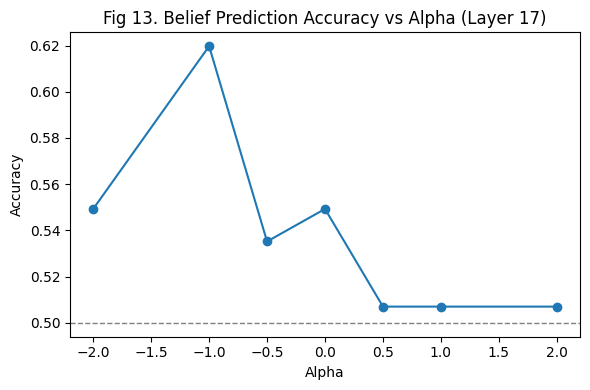

In [18]:
import matplotlib.pyplot as plt

alphas_sorted = sorted(accuracies.keys())
acc_values = [accuracies[a] for a in alphas_sorted]
plt.figure(figsize=(6, 4))
plt.plot(alphas_sorted, acc_values, marker="o")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Fig 13. Belief Prediction Accuracy vs Alpha (Layer 17)")
plt.tight_layout()
plt.show()

### by layer

Layers:   0%|          | 0/12 [00:00<?, ?it/s]

alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=0: accuracy=0.493


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=3: accuracy=0.521


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=6: accuracy=0.493


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=9: accuracy=0.535


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=12: accuracy=0.521


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=15: accuracy=0.507


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=18: accuracy=0.563


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=21: accuracy=0.521


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=24: accuracy=0.521


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=27: accuracy=0.521


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=30: accuracy=0.535


alpha -1:   0%|          | 0/71 [00:00<?, ?it/s]

layer=31: accuracy=0.549


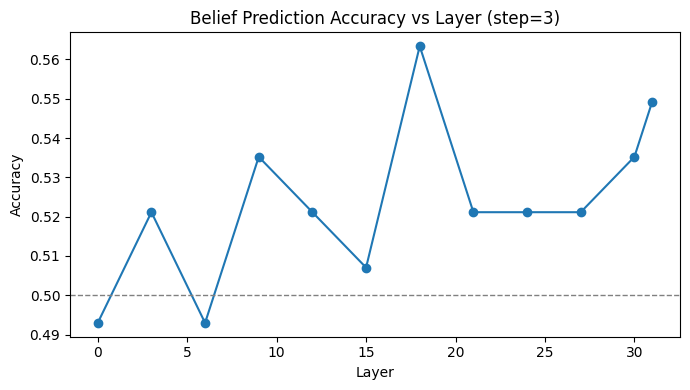

In [15]:
# --- By-layer evaluation (skip 3 layers) ---
LAYER_STEP = 3
LAYER_SWEEP_ALPHA = 1  # change if you want steering during layer sweep
num_layers = model.config.num_hidden_layers
layer_list = list(range(0, num_layers, LAYER_STEP))
if (num_layers - 1) not in layer_list:
    layer_list.append(num_layers - 1)

layer_accuracies = {}
layer_iter = tqdm(layer_list, desc="Layers")
for layer_idx in layer_iter:
    direction_l, instruction_len_l = compute_steering_direction(
        df_direction, tokenizer, model, layer_idx, TOKEN_RULE,
        batch_size=BATCH_SIZE, max_tokens=MAX_PROMPT_TOKENS,
    )
    acc = evaluate_accuracy(
        examples, model, tokenizer, direction_l, LAYER_SWEEP_ALPHA, layer_idx, instruction_len_l,
    )
    layer_accuracies[layer_idx] = acc
    print(f"layer={layer_idx}: accuracy={acc:.3f}")


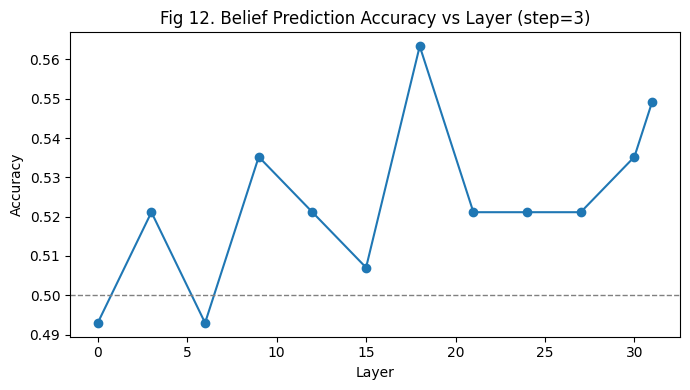

In [17]:

layers_sorted = sorted(layer_accuracies.keys())
acc_by_layer = [layer_accuracies[l] for l in layers_sorted]
plt.figure(figsize=(7, 4))
plt.plot(layers_sorted, acc_by_layer, marker="o")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title(f"Fig 12. Belief Prediction Accuracy vs Layer (step={LAYER_STEP})")
plt.tight_layout()
plt.show()

In [10]:
# --- Controls vs baseline (layer 17, alpha -1) ---
CONTROL_LAYER = 17
CONTROL_ALPHA = -1.0

direction_base, instruction_len_base = compute_steering_direction(
    df_direction, tokenizer, model, CONTROL_LAYER, TOKEN_RULE,
    batch_size=BATCH_SIZE, max_tokens=MAX_PROMPT_TOKENS,
 )
baseline_acc = evaluate_accuracy(
    examples, model, tokenizer, direction_base, CONTROL_ALPHA, CONTROL_LAYER, instruction_len_base,
 )

rng = torch.Generator(device="cpu").manual_seed(0)
rand_dir = torch.randn(direction_base.numel(), generator=rng)
rand_dir = rand_dir / (rand_dir.norm() + 1e-8)
rand_acc = evaluate_accuracy(
    examples, model, tokenizer, rand_dir, CONTROL_ALPHA, CONTROL_LAYER, instruction_len_base,
 )

df_shuffled = df_direction.copy()
df_shuffled[REFRAME_COL] = df_shuffled[REFRAME_COL].sample(frac=1.0, random_state=0).values
direction_shuf, instruction_len_shuf = compute_steering_direction(
    df_shuffled, tokenizer, model, CONTROL_LAYER, TOKEN_RULE,
    batch_size=BATCH_SIZE, max_tokens=MAX_PROMPT_TOKENS,
 )
shuf_acc = evaluate_accuracy(
    examples, model, tokenizer, direction_shuf, CONTROL_ALPHA, CONTROL_LAYER, instruction_len_shuf,
)

alpha -1.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha -1.0:   0%|          | 0/71 [00:00<?, ?it/s]

alpha -1.0:   0%|          | 0/71 [00:00<?, ?it/s]

NameError: name 'plt' is not defined

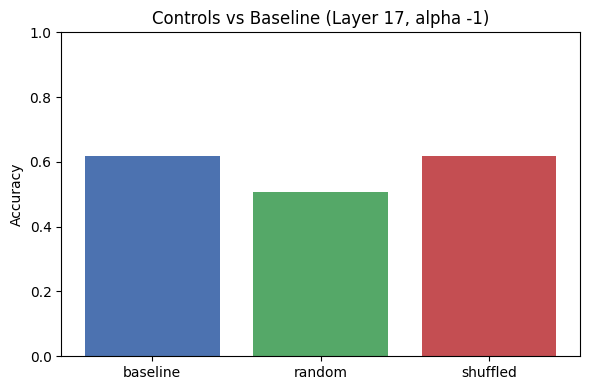

In [12]:
import matplotlib.pyplot as plt

labels = ["baseline", "random"]
values = [baseline_acc, rand_acc]
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["#4c72b0", "#55a868"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Controls vs Baseline (Layer 17, alpha -1)")
plt.tight_layout()
plt.show()

# Control